In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_blobs, load_digits, make_moons, load_sample_image
from sklearn.cluster import KMeans, SpectralClustering, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from scipy.stats import mode

plt.style.use('seaborn-v0_8-whitegrid')

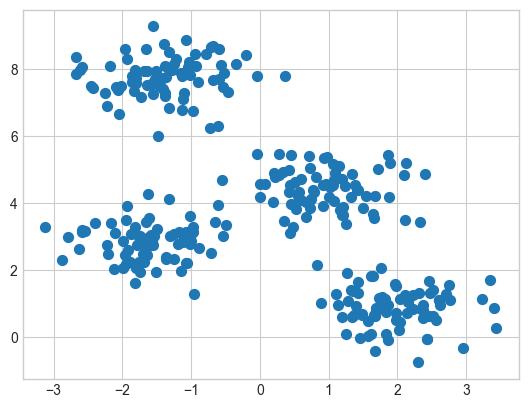

In [2]:
# the k-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset. It acomplishes this using a simple conception of what the optimal clustering looks like:
# 1. The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
# 2. Each point is closer to its own cluster center than to other cluster centers.
# Those two assumptions are the basis of the k-means model. We will soon dive into exactly how the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the k-means result.
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

In [3]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


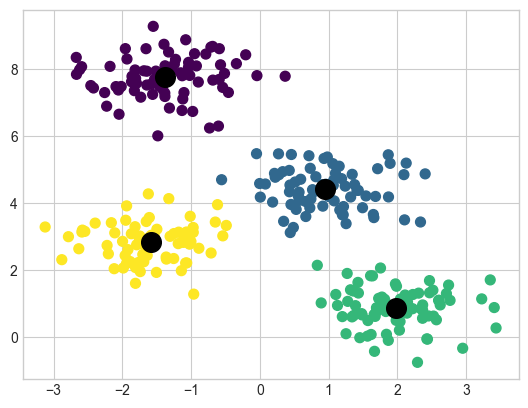

In [6]:
# we will also plot the cluster centers as determined by the k-means estimator:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap="viridis")
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200)
# the good news is that the k-means algorithm assigns the points to clusters very similarly to how we might assign them by eye. But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly. Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to k-means involves an intuitive iterative approach known as expectation–maximization.

Expectation-maximization

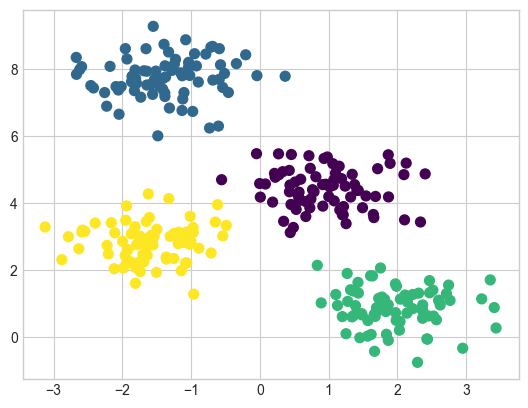

In [14]:
# the expectation–maximization approach here proceeds as follows
# 1. Guess some cluster centers
# 2. Repeat until converged
#     a. E-Step: assign points to the nearest cluster center
#     b. M-Step: set the cluster centers to the mean
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels


centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="viridis")
# most well-tested implementations will do a bit more than this under the hood but the preceding function gives the gist of the expectation–maximization approach.

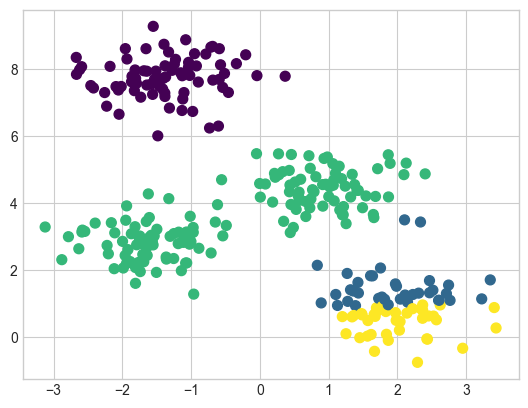

In [15]:
# the global optimal result may not be achieved
# first although the E-M procedure is gaurenteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="viridis")

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


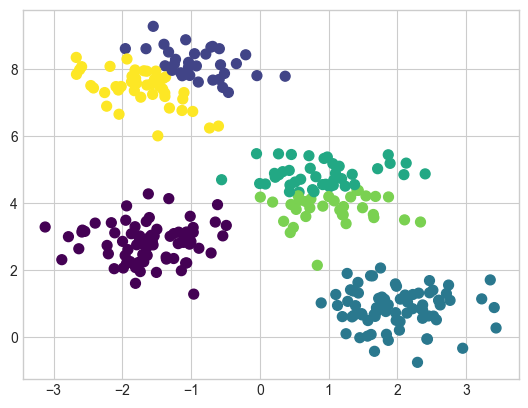

In [16]:
# the numbers of clusters must be selected beforehand
# another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data. For example if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="viridis")

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


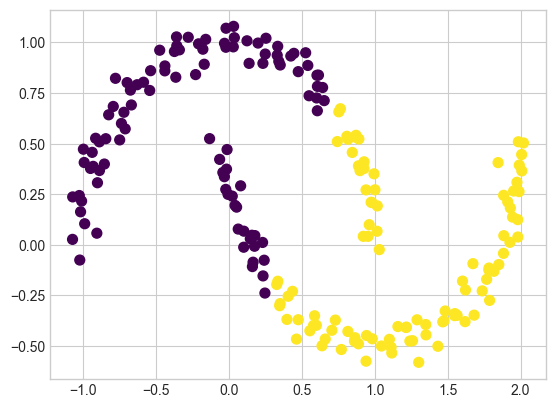

In [18]:
# k-means is limited to linear cluster boundaries
# the fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries. In particular the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical k-means approach:
X, y = make_moons(200, noise=0.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="viridis")

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


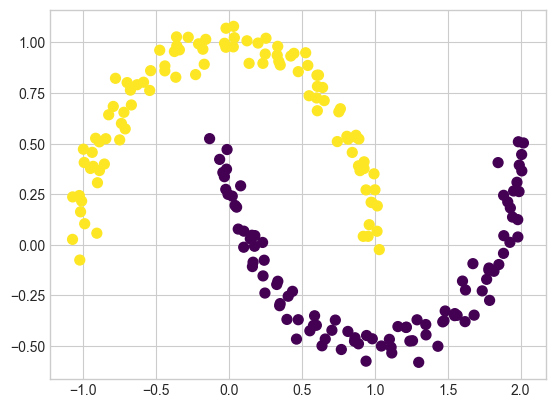

In [19]:
# one version of this kernelized k-means is implemented in Scikit-Learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:
model = SpectralClustering(
    n_clusters=2, affinity="nearest_neighbors", assign_labels="kmeans"
)
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="viridis")

In [20]:
# example: k-means on digits
# we will try to identify similar digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.
digits = load_digits()
digits.data.shape

(1797, 64)

In [21]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(10, 64)

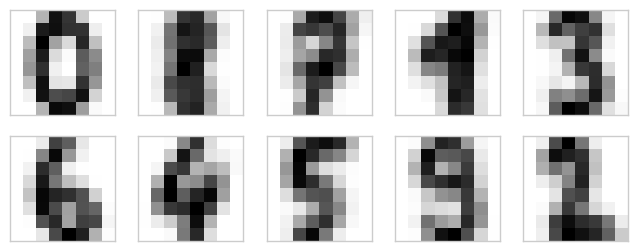

In [22]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation="nearest", cmap=plt.cm.binary)

In [24]:
# even without labels kmeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8 becuase k means knwos nothing about the identities of the clusters the labels may be permuted. we can fix this by matching each learned cluster label with the true labels found in them:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = clusters == i
    labels[mask] = mode(digits.target[mask])[0]

accuracy_score(digits.target, labels)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_28392/3630178322.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(digits.target[mask])[0]


0.7918753478018921

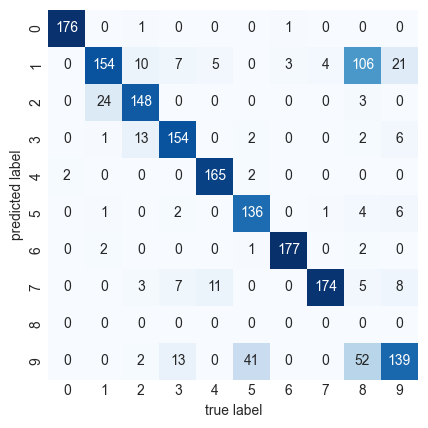

In [26]:
# we got 80% accuracy without using the label information! Lets check the confusion matrix for this:
mat = confusion_matrix(digits.target, labels)
sns.heatmap(
    mat.T,
    square=True,
    annot=True,
    fmt="d",
    cbar=False,
    cmap="Blues",
    xticklabels=digits.target_names,
    yticklabels=digits.target_names,
)
plt.xlabel("true label")
plt.ylabel("predicted label")

In [27]:
# the main point of confusion is between the eights and ones but this still showsx that using k-means we can essentially build a digit classifier without reference to any known labels!
# we can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. lets see how it does:
# project the data: this step will take several seconds
tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=0)
digits_proj = tsne.fit_transform(digits.data)
# compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)
# permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = clusters == i
    labels[mask] = mode(digits.target[mask])[0]
# compute the accuracy
accuracy_score(digits.target, labels)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_28392/164501921.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(digits.target[mask])[0]


0.9415692821368948

K-means for color compression

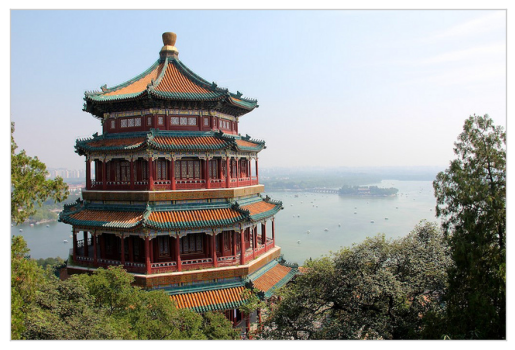

In [28]:
# one interesting application of clustering is in color compression within images. for example imagine you have an image with millions of colors. in most images a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors. for example consider the image shown in the following figure,
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

In [29]:
china.shape

(427, 640, 3)

In [30]:
# one way we can view this set of pixels is as a cloud of points in a three-dimensional color space. we will reshape the data to [n_samples x n_features], and rescale the colors so that they lie between 0 and 1:
data = china / 255.0  # use 0...1 scale
data = data.reshape(-1, 3)
data.shape

(273280, 3)

In [31]:
# we can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker=".")
    ax[0].set(xlabel="Red", ylabel="Green", xlim=(0, 1), ylim=(0, 1))
    ax[1].scatter(R, B, color=colors, marker=".")
    ax[1].set(xlabel="Red", ylabel="Blue", xlim=(0, 1), ylim=(0, 1))
    fig.suptitle(title, size=20)

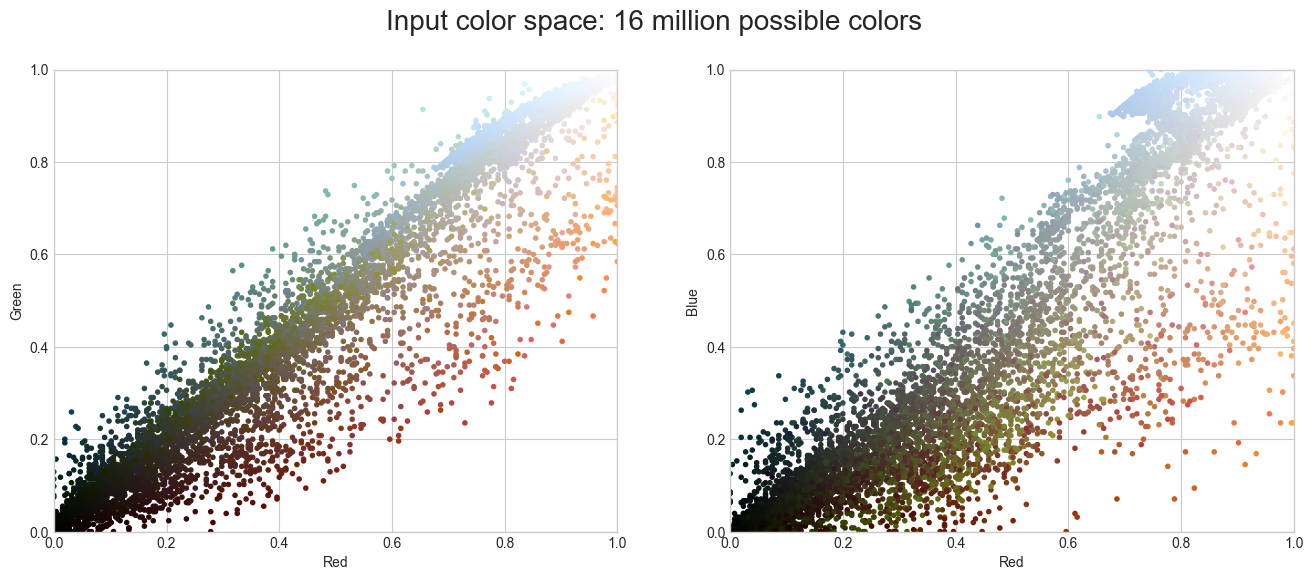

In [32]:
plot_pixels(data, title="Input color space: 16 million possible colors")

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


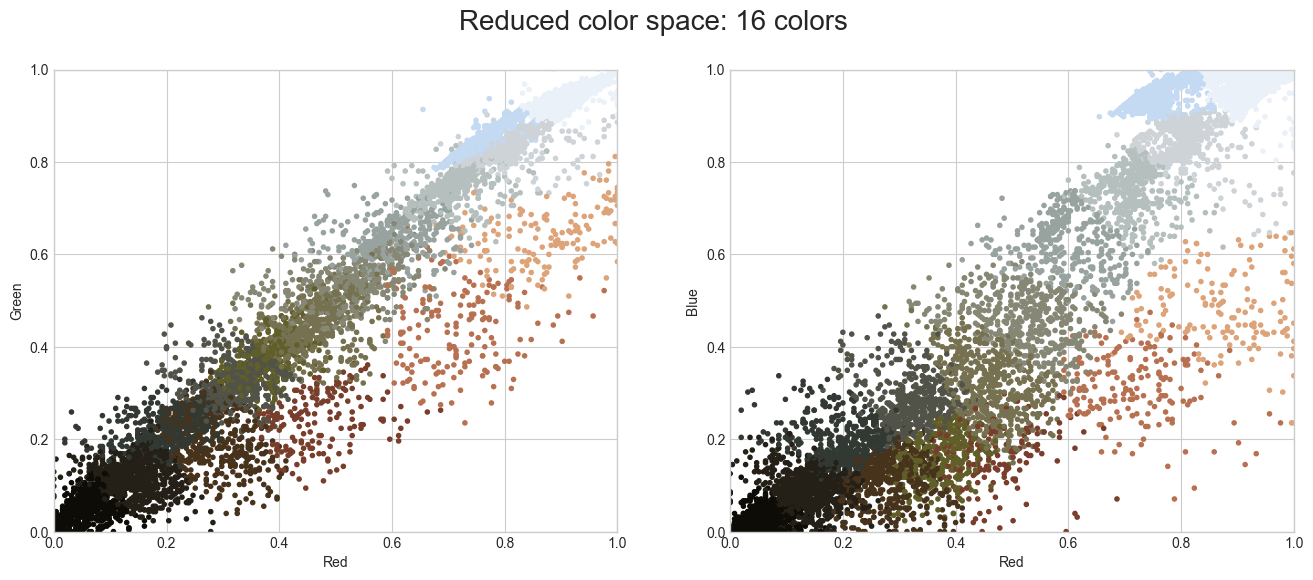

In [33]:
# now we can reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

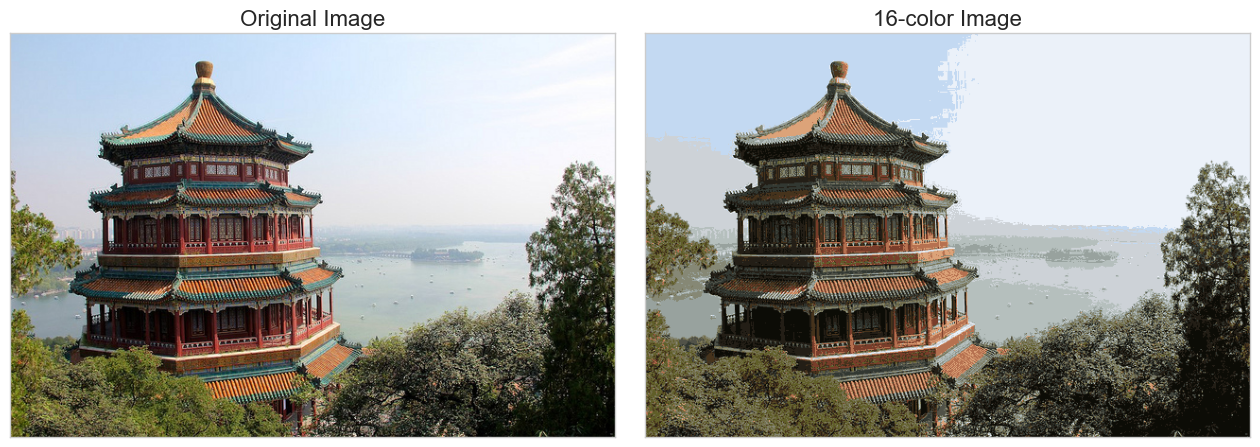

In [34]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title("Original Image", size=16)
ax[1].imshow(china_recolored)
ax[1].set_title("16-color Image", size=16)